# 注意力机制
1、卷积、全连接、池化层只考虑不随意线索  
2、注意力机制则显式地考虑随意线索  
（1）随意线索被称之为查询（query）  
（2）每个输入是一个值（value）和不随意线索（key）的对  
（3）通过注意力池化层来有偏向性的选择某些输入  
3、非参注意力池化层  
（1）给定数据（$x_i,y_i$）,$i=1,\cdots,n$  
（2）平均池化最简单：$f(x)=\frac{1}{n}\sum_i y_i$  
（3）更好的方案是核回归：  
<img src="../pics/1.png" width="35%" />  
4、参数化的注意力机制  
在之前基础上引入可以学习的$w$:
$$ f(x)=\sum_{i=1}^n softmax(-\frac{1}{2}((x-x_i)w)^2)y_i $$
5、注意力机制中，通过query和key来有偏向性的选择输入，可以一般的写作：$f(x)=\sum_i \alpha (x,x_i)y_i$

In [3]:
# 注意力汇聚：Nadaraya-Watson核回归
import torch
from torch import nn
from d2l import torch as d2l


In [ ]:
# 生成简单数据集
n_train = 50
x_train,_=torch.sort(torch.rand(n_train)*5)

def f(x):
    return 2*torch.sin(x)+x**0.8
y_train=f(x_train)+torch.normal(0.0,0.5,(n_train,))
x_test=torch.arange(0,5,0.1)
print(x_test)
y_truth=f(x_test)
n_test=len(x_test)

def plot_kernel_reg(y_hat):
    d2l.plot(x_test,[y_truth,y_hat],'x','y',legend=["Truth","pred"],xlim=[0,5],ylim=[-1,5])
    d2l.plt.plot(x_train,y_train,'o',alpha=0.5)
y_hat=torch.repeat_interleave(y_train.mean(),n_test)
plot_kernel_reg(y_hat)

# 注意力评分函数
0、注意力分数框架：  
<img src="../pics/2.png" width="35%" />  
<img src="../pics/3.png" width="35%" />  
1、注意力池化层：  
假设有一个查询$q\in R^q$和m个“键-值”对$(k_1,v_1),\cdots,(k_m,v_m)$，其中$k_i\in R^k,v_i \in R^v$，注意力汇聚函数f可被表示成值的加权和
$$ f(\mathbf{q}, (\mathbf{k}_1, \mathbf{v}_1), \dots, (\mathbf{k}_m, \mathbf{v}_m)) = \sum_{i=1}^{m} \alpha(\mathbf{q}, \mathbf{k}_i)\mathbf{v}_i \in \mathbb{R}^v, $$
其中查询q和键$k_i$的注意力权重是通过注意力评分函数$a$将两个向量映射成标量，再经过softmax运算得到的：
$$ \alpha(\mathbf{q}, \mathbf{k}_i) = \text{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^{m} \exp(a(\mathbf{q}, \mathbf{k}_j))} \in \mathbb{R}. $$  
1.1、掩蔽softmax操作：任何超出有效长度的位置都被掩蔽并置为0  


In [4]:
import math
import torch
from torch import nn
from d2l import torch as d2l

# softmax-mask操作
def masked_softmax(X,valid_lens):
    """ 通过在最后一个轴上掩蔽元素来执行softmax操作 """
    # X：3D张量(batch_size, num_queries, num_keys)
    # valid_lens:1D张量（第i个样本前L个有效）或2D张量（每个查询具体的有效长度）
    if valid_lens is None:
        return nn.functional.softmax(X,dim=-1)
    else:
        shape=X.shape
        if valid_lens.dim()==1:
            valid_lens=torch.repeat_interleave(valid_lens,shape[1])
        else:
            valid_lens=valid_lens.reshape(-1)
        # 最后一轴上被遮蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X=d2l.sequence_mask(X.reshape(-1,shape[-1]),valid_lens,value=-1e6)
        return nn.functional.softmax(X.reshape(shape),dim=-1)
#考虑由两个2*4矩阵表示的样本， 这两个样本的有效长度分别为2和3。 经过掩蔽softmax操作，超出有效长度的值都被掩蔽为0
print(masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3])))
# 同样，也可以使用二维张量，为矩阵样本中的每一行指定有效长度。
print(masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]])))






tensor([[[0.6328, 0.3672, 0.0000, 0.0000],
         [0.6298, 0.3702, 0.0000, 0.0000]],

        [[0.2965, 0.2170, 0.4865, 0.0000],
         [0.4466, 0.2969, 0.2565, 0.0000]]])
tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2797, 0.2639, 0.4564, 0.0000]],

        [[0.3911, 0.6089, 0.0000, 0.0000],
         [0.2673, 0.2144, 0.2741, 0.2441]]])


2、Additive Attention（加性注意力）  
当查询q和键k是不同长度的矢量时，可以使用加性注意力作为评分函数。给定$q\in R^q,k\in R^k$，加性注意力的评分函数为：
$$ a(q,k)=w_v^T tanh(W_q q+W_k k) \in R $$
可学参数：$W_k \in R^{h\times k},W_q\in R^{h\times q},w_v\in R^h$

等价于将query和key合并起来放入到隐藏层大小为h输出维度为1的单隐藏层MLP

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)


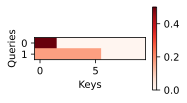

In [5]:
class AdditiveAttention(nn.Module):
    """ 加性注意力 """
    def __init__(self,key_size,query_size,num_hiddens,dropout,**kwargs):
        super(AdditiveAttention,self).__init__(**kwargs)
        self.W_k=nn.Linear(key_size,num_hiddens,bias=False)
        self.W_q=nn.Linear(query_size,num_hiddens,bias=False)
        self.w_v=nn.Linear(num_hiddens,1,bias=False)
        self.dropout=nn.Dropout(dropout)

    def forward(self,queries,keys,values,valid_lens):
        queries,keys = self.W_q(queries),self.W_k(keys)
        # quries形状：（batch_size,查询个数，1，num_hiddens）
        # keys的形状：（batch_size,1,“键-值”对个数，num_hiddens）
        # 使用广播方式进行求和(例如queries的（查询个数，1）变成（查询个数，“键-值”对个数）)
        features=queries.unsqueeze(2)+keys.unsqueeze(1)
        features=torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights=masked_softmax(scores,valid_lens)
        # values的形状：（batch_size，“键-值”对的个数，值的维度）
        return torch.bmm(self.dropout(self.attention_weights),values)

queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,dropout=0.1)
attention.eval()
#queries:(2,1,10),keys:(2,10,2),value:(2,10,4),scores:(2,1,10),输出是(2,1,4)——batch_size,查询个数,值的维度
print(attention(queries, keys, values, valid_lens))

d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

3、缩放点积注意力  
（1）假设查询和键的所有元素都是独立的随机变量， 并且都满足零均值和单位方差， 那么两个向量的点积的均值为0，方差为d（q和k的长度），因此将点积除以$\sqrt(d)$，将方差归一化，得到缩放点积注意力评分函数：
$$ a(q,k)=\frac{q^Tk}{\sqrt{d}} $$
（2）在实践中，我们通常从小批量的角度来考虑提高效率。例如基于n个查询和m个键-值对计算注意力，其中查询和键的长度为d，值的长度为v。查询$Q\in R^{n\times d}$键$K\in R^{m\times d}$，值$V\in R^{m\times v}$，那么缩放点积注意力是：
$$ softmax(\frac{QK^T}{\sqrt{d}})V \in R^{n\times v} $$

In [16]:
class DotProductAttention(nn.Module):
    """ 缩放点积注意力 """
    def __init__(self,dropout,**kwargs):
        super(DotProductAttention,self).__init__(**kwargs)
        self.dropout=nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self,queries,keys,values,valid_lens=None):
        d=queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores=torch.bmm(queries,keys.transpose(1,2))/math.sqrt(d)
        self.attention_weights=masked_softmax(scores,valid_lens)
        return torch.bmm(self.dropout(self.attention_weights),values)

# 同样的例子
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[4., 5., 6., 7.]],

        [[2., 3., 4., 5.]]])

# Bahdanau注意力
Bahdanau注意力：没有严格单向对齐限制的可微注意力模型。在预测词元时，如果不是所有输入词元都相关，模型将仅对齐（或参与）输入序列中与当前预测相关的部分。这是通过将上下文变量视为注意力集中的输出来实现的。  
1、模型  
（1）上下文变量c在任何解码时间步t'都会被$c_{t^{'}}$替换。假设输入序列中有T个词元， 解码时间步t'的上下文变量是注意力集中的输出：
$$ c_{t^{'}}=\sum_{t=1}^T \alpha(s_{t^{'}-1},h_t)h_t $$
其中时间步t'-1时的解码器隐状态$s_{t^{'}-1}$是查询，编码器隐状态$h_t$既是键，也是值，注意力权重$\alpha$如上定义。
（2）Bahdanau注意力框架图如下：  
<img src="../pics/4.png" width="35%" />   
2、定义注意力解码器  
初始化解码器的状态，需要下面的输入：  
（1）编码器在所有时间步的最终层隐状态，将作为注意力的键和值；  
（2）上一时间步的编码器全层隐状态，将作为初始化解码器的隐状态；  
（3）编码器有效长度（排除在注意力池中填充词元）  
在每个解码时间步骤中，解码器上一个时间步的最终层隐状态将用作查询。 因此，注意力输出和输入嵌入都连结为循环神经网络解码器的输入。

In [23]:
import torch
from torch import nn
from d2l import torch as d2l

#@save
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError
    
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self,vocab_size, embed_size, num_hiddens, num_layers,dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder,self).__init__(**kwargs)
        # 前两个num_hiddens实则是k和q的大小
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding=nn.Embedding(vocab_size,embed_size)
        # RNN输入不仅是当前词向量embed_size，还有上下文向量num_hiddens
        self.rnn=nn.GRU(embed_size+num_hiddens,num_hiddens,num_layers,dropout=dropout)
        self.dense=nn.Linear(num_hiddens,vocab_size)
    
    def init_state(self,enc_outputs,enc_valid_lens,*args):
        # outputs:(bacth_size,num_steps（句子长度）,num_hiddens)
        # hidden_state:(num_layers,batch_size,num_hiddens)
        outputs,hidden_state=enc_outputs
        return (outputs.permute(1,0,2),hidden_state,enc_valid_lens)
        #return (outputs, hidden_state, enc_valid_lens)
    
    def forward(self,X,state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,num_hiddens)
        enc_outputs,hidden_state,enc_valid_lens=state # 刚好是前面说的是三个输入
        X=self.embedding(X).permute(1,0,2) # (num_steps,batch_size,embed_size)
        outputs,self._attention_weights=[],[]
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            # hidden_state[-1]相当于最后一层RNN（解码器上一个时间步的最终层隐状态将用作查询）
            query=torch.unsqueeze(hidden_state[-1],dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context=self.attention(query,enc_outputs,enc_outputs,enc_valid_lens)
            # 在特征维度上联结
            x=torch.cat((context,torch.unsqueeze(x,dim=1)),dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # outputs:(num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights
    
# 接下来，使用包含7个时间步的4个序列输入的小批量测试Bahdanau注意力解码器。
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,num_layers=2)
decoder.eval()
# X:(batch_size,num_steps)=(4,7)
X = torch.zeros((4, 7), dtype=torch.long)
# state=enc_outputs,hidden_state,enc_valid_lens
# enc_outputs:(num_steps,batch_size,hidden_dim)=(7,4,16)
# hidden_state:(layers,bacth_size,hideen_dim)=(2,4,16)
state = decoder.init_state(encoder(X), None)
# output:(batch_size,num_steps,vocab_size)
output, state = decoder.forward(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape



(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

In [ ]:
# 修改一下源代码，否则版本不兼容
def train_seq2seq_local(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence.

    Defined in :numref:`sec_utils`"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = d2l.MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = d2l.concat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat= net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')
    

def predict_seq2seq_local(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """ 
    src_vocab:源语言词表,把源端 token 映射为 id
    src_vocab['<eos>']:结束符的id
    src_vocab['<pad>']:填充符的id
    tgt_vocab:目标语言词表,把目标端 token ↔ id 互相转换
    tgt_vocab['<bos>']:解码起始输入的id
    tgt_vocab['<eos>']:停止的id
    """
    # 1. 切换模式：告诉模型“现在是考试，别用 Dropout，别更新 BatchNorm”
    net.eval()
    # 2. 查字典：把英文句子 "I love you" 变成数字索引 [12, 45, 99, <eos>]
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    # 3. 记长度：比如长度是 4。这对应 enc_valid_lens，告诉编码器别看 padding
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    # 4. 截断/填充：凑成固定长度 num_steps（比如 10），不足补 <pad>
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 5. 加 Batch 维：变成 (1, 10)，假装这是一个 batch_size=1 的数据
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    # 6. 【关键】编码器开工：一次性读完整个句子，生成 enc_outputs
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    # 7. 打包行李：把编码器的输出、有效长度打包进 state（state[2]现在是[None] * self.num_layers）
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 8. 准备第一个输入：<bos> (Beginning of Sentence)
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        # 9. 【核心动作】解码器生成一步
        #    输入 dec_X: 只有当前这 1 个词（比如 <bos> 或 上一步生成的词）
        #    输入 dec_state: 背包里装着所有的历史记忆（KV Cache）
        #    输出 Y: 对下一个词的概率预测，形状 (1, 1, vocab_size)
        #    输出 dec_state: 更新后的背包（KV Cache 变长了！
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 10. 贪婪搜索 (Greedy Search)：选概率最大的那个词
        dec_X = Y.argmax(dim=2)
        # 11. 把 Tensor 变成 Python 整数，方便后续判断
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 12. 保存当前 decoder 里的注意力权重，方便可视化
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights())
        # 13. 如果预测出了 <eos> (End of Sentence)，说明模型觉得句子说完了，直接交卷
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [ ]:
# 模型训练
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs = 0.005, 250

# 自动检测：如果有显卡就用 cuda，没有就回退到 cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"当前正在使用的设备: {device}")

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq_local(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))
# 加上一个包含序列结束词元
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')


# 多头注意力
与其只使用单独一个注意力汇聚，我们可以用独立学习得到的h组不同的线性投影来变换插叙、键和值。然后，这h组变换后的查询、键和值将并行地送到注意力汇聚中。最后，将这h个注意力汇聚的输出拼接在一起， 并且通过另一个可以学习的线性投影进行变换， 以产生最终输出。 这种设计被称为多头注意力（multihead attention）。  
多头注意力框架如下：  
<img src="../pics/5.png" width="35%" />  
1、模型  
（1）给定查询$q\in R^{d_q}$、键$k\in R^{d_k}$和值$v\in R^{d_v}$，每个注意力头$h_i(i=1,\cdots,h)$的计算方式为：
$$ h_i=f(W_i^{(q)}q,W_i^{(k)}k,W_i^{(v)}v)\in R^{(p_v)} $$
其中，可学习的参数包括$W_i^{(q)}\in R^{p_q \times d_q},W_i^{(k)}\in R^{p_k \times d_k},W_i^{(v)}\in R^{p_v \times d_v}$，以及代表注意力汇聚的函数f。f可以是前文的加性注意力，也可以是缩放点积注意力。  
（2） 多头注意力的输出需要经过另一个线性转换， 它对应着h个头连结后的结果，因此其可学习参数是$W_o \in R^{p_o\times h{p_v}}$:
$$ \mathbf{W}_o \begin{bmatrix} \mathbf{h}_1 \\ \vdots \\ \mathbf{h}_h \end{bmatrix} \in \mathbb{R}^{p_o}. $$
基于这种设计，每个头都可能会关注输入的不同部分， 可以表示比简单加权平均值更复杂的函数。  
2、实现  
在实现过程中通常选择缩放点积注意力作为每一个注意力头。为了避免计算代价和参数代价的大幅增长，我们设定$p_q=p_k=p_v=p_o/h$，则可以并行计算h个头。  



In [7]:
import math
import torch
from torch import nn
from d2l import torch as d2l

def transpose_qkv(X,num_heads):
    """ 为了多注意力头的并行计算而变换形状 """
    # 输入X的形状：(batch_size，查询或者“键-值”对的个数，num_hiddens)

    # 输出X的形状：（batch_size，查询或者“键-值”对的个数，num_heads，num_hiddens/num_heads）
    X=X.reshape(X.shape[0],X.shape[1],num_heads,-1)

    # 输出X的形状：（batch_size，num_head，查询或者“键-值”对的个数，num_hiddens/num_heads）
    X=X.permute(0,2,1,3)

    # 最终输出形状：(batch_size*num_heads,查询或者“键－值”对的个数,num_hiddens/num_heads)
    return X.reshape(-1,X.shape[2],X.shape[3])

def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)


class MultiHeadAttention(nn.Module):
    """ 多头注意力 """
    # num_hiddens(相当于前文的p0=num_heads*head_size)
    def __init__(self,key_size,qurey_size,value_size,num_hiddens,num_heads,dropout,bias=False,**kwargs):
        super(MultiHeadAttention,self).__init__(**kwargs)
        self.num_heads=num_heads
        self.attention=DotProductAttention(dropout)
        self.W_q=nn.Linear(qurey_size,num_hiddens,bias=bias)
        self.W_k=nn.Linear(key_size,num_hiddens,bias=bias)
        self.W_v=nn.Linear(value_size,num_hiddens,bias=bias)
        self.W_o=nn.Linear(num_hiddens,num_hiddens,bias=bias)

    def forward(self,queries,keys,values,valid_lens):
        # queries，keys，values的形状类似：(batch_size,查询/键值对数,num_hiddens)
        # valid_size形状：（batch_size,）或（batch_size,查询的个数）

        # 经过变换后，输出的queries，keys，values　的形状: 
        # (batch_size*num_heads，查询或者“键－值”对的个数，num_hiddens/num_heads=head_size)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # batch_size维度扩大了num_heads倍，所以需要相应的复制过去
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，然后如此复制第二项，然后诸如此类
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)

        # output的形状：(batch_size*num_heads，查询的个数，num_hiddens/num_heads)
        # 这里的num_hiddens/num_heads相当于值的维度（被切分成了num_heads个）
        output = self.attention(queries,keys,values,valid_lens)
        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output,self.num_heads)
        return self.W_o(output_concat)

# 测试例子，多头注意力输出的形状是（batch_size，num_queries，num_hiddens）
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens =  6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape


torch.Size([2, 4, 100])

# 自注意力和位置编码
同一组次元同时充当查询、键和值， 由于查询、键和值来自同一组输入，因此被称为 自注意力（self-attention）
1、自注意力  
给定一个由词元组成的输入序列$x_1,\cdots,x_n$，其中任意$x_i\in R^d$。该序列的自注意力输出位一个长度相同的序列$y_i,\cdots,y_n$，其中：
$$ y_i=f(x_i,(x_1,x_1),\cdots,(x_n,x_n)) \in R^d$$
2、比较CNN、RNN和自注意力  
<img src="../pics/6.png" width="35%" />  
卷积神经网络和自注意力都拥有并行计算的优势， 而且自注意力的最大路径长度最短。 但是因为其计算复杂度是关于序列长度的二次方，所以在很长的序列中计算会非常慢。

In [9]:
import math
import torch
from torch import nn
from d2l import torch as d2l

num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                   num_hiddens, num_heads, 0.5)
attention.eval()

batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

3、位置编码  
自注意力因为并行计算，放弃了顺序操作，为了使用序列的顺序信息，通过在输入中添加位置编码（positional encoding）来注入绝对的或相对的位置信息。 位置编码可以通过学习得到也可以直接固定得到。接下来描述是基于正弦函数和余弦函数的固定位置编码。  
假设输入表示$X\in R^{n\times d}$包含一个序列中n个词元的d维嵌入表示。位置编码使用相同形状的位置嵌入矩阵$P\in R^{n\times d}$输出$X+P$，矩阵第i行、第2j列和第2j+1列上的元素为：
\begin{aligned}
p_{i, 2j} &= \sin\left( \frac{i}{10000^{2j/d}} \right), \\
p_{i, 2j+1} &= \cos\left( \frac{i}{10000^{2j/d}} \right).
\end{aligned}

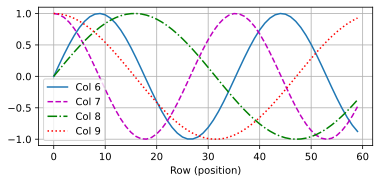

In [10]:
class PositionalEncoding(nn.Module):
    """ 位置编码 """
    def __init__(self,num_hiddens,dropout,max_len=1000):
        super(PositionalEncoding,self).__init__()
        self.dropout=nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P=torch.zeros(1,max_len,num_hiddens)
        X = torch.arange(max_len,dtype=torch.float32).reshape(-1,1)/torch.pow(
            10000,torch.arange(0,num_hiddens,2,dtype=torch.float32)/num_hiddens)

        self.P[:,:,0::2] = torch.sin(X)
        self.P[:,:,1::2] = torch.cos(X)
    
    def forward(self,X):
        # 只考虑X的维度即可
        X=X+self.P[:,:X.shape[1],:].to(X.device)
        return self.dropout(X)

encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

（1）绝对位置信息  
在二进制表示中，较高比特位的交替频率低于较低比特位，位置编码通过使用三角函数在编码维度上降低频率。 由于输出是浮点数，因此此类连续表示比二进制表示法更节省空间。  
（2）相对位置信息  
<img src="../pics/7.png" width="35%" />



# Transformer
Transformer模型完全基于注意力机制，没有任何卷积层或循环神经网络层  
1、模型  
Transformer是由编码器和解码器组成的，Transformer的编码器和解码器是基于自注意力的模块叠加而成的，源（输入）序列和目标（输出）序列的嵌入（embedding）表示将加上位置编码（positional encoding），再分别输入到编码器和解码器中。  
<img src="../pics/8.png" width="35%" />  
（1）编码器第一个子层：多头自注意力（multi-head self-attention）汇聚  
（2）编码器第二个子层：基于位置的前馈网络（positionwise feed-forward network）  
每个子层采用残差连接（ResNet的思路），对于任何位置的任何输入$x\in R^d$，都要求满足$sublayer(x) \in R^d$，以便$x+sublayer(x)\in R^d$。在残差连接的加法计算之后，紧接着应用层规范化（layer normalization）。  
（3）Transformer解码器也是由多个相同的层叠加而成，并且层中使用了残差连接和层规范化。除了编码器中描述的两个子层之外，解码器还在这两个子层之间插入了第三个子层，称为编码器－解码器注意力（encoder-decoder attention）层。在编码器－解码器注意力中，查询来自前一个解码器层的输出，而键和值来自整个编码器的输出。  
（4）在解码器自注意力中，查询、键和值都来自上一个解码器层的输出。但是，解码器中的每个位置只能考虑该位置之前的所有位置。这种掩蔽（masked）注意力保留了自回归（auto-regressive）属性，确保预测仅依赖于已生成的输出词元。  
2、基于位置的前馈网络（FNN层）  
基于位置的前馈网络对序列中的所有位置的表示进行变换时使用的是同一个多层感知机（MLP），这就是称前馈网络是基于位置的（positionwise）的原因。





In [11]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
class PositionWiseFFN(nn.Module):
    """ 基于位置的前馈神经网络FNN """
    def __init__(self,ffn_num_input,ffn_num_hiddens,ffn_num_outputs,**kwargs):
        super(PositionWiseFFN,self).__init__(**kwargs)
        self.dense1=nn.Linear(ffn_num_input,ffn_num_hiddens)
        self.relu=nn.ReLU()
        self.dense2=nn.Linear(ffn_num_hiddens,ffn_num_outputs)
    # 输入X的形状（batch_size，time_steps，隐单元数或特征维度ffn_num_input）
    def forward(self,X):
        return self.dense2(self.relu(self.dense1(X)))
    
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.1910, -1.0003,  0.3826, -0.9186,  0.2532, -1.1676,  0.0134,  0.6793],
        [-0.1910, -1.0003,  0.3826, -0.9186,  0.2532, -1.1676,  0.0134,  0.6793],
        [-0.1910, -1.0003,  0.3826, -0.9186,  0.2532, -1.1676,  0.0134,  0.6793]],
       grad_fn=<SelectBackward0>)

3、残差连接和层规范化  
（1）层规范化（Layer Normalization）是基于特征维度进行规范化：固定某一行（样本），统计样本所有特征的均值与方差  
（2）批规范化（Batch Normalization）固定某一列特征，统计所有样本在这一列的均值与方差  
（3）可以使用残差连接和层规范化来实现AddNorm类

In [14]:
class Addnorm(nn.Module):
    """ 残差连接后进行层规范化 """
    def __init__(self,normalized_shape,dropout,**kwargs):
        super(Addnorm,self).__init__(**kwargs)
        self.dropout=nn.Dropout(dropout)
        self.ln=nn.LayerNorm(normalized_shape)
    
    def forward(self,X,Y):
        return self.ln(self.dropout(Y)+X)
add_norm=Addnorm([3,4],0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape






torch.Size([2, 3, 4])

4、编码器  
（1）下面的EncoderBlock类包含两个子层：多头自注意力和基于位置的前馈网络，这两个子层都使用了残差连接和紧随的层规范化。  
（2）下面实现的Transformer编码器的代码中，堆叠了num_layers个EncoderBlock类的实例。由于这里使用的是值范围在0和1之间的固定位置编码，因此通过学习得到的输入的嵌入表示的值需要先乘以嵌入维度的平方根进行重新缩放，然后再与位置编码相加。（否则位置编码把本身的语义信息稀释了，而Xavier 初始化导致每个元素方差变成1/d）

In [18]:
class EncoderBlock(nn.Module):
    """ Transformer编码器块 """
    def __init__(self,key_size,query_size,value_size,num_hiddens,norm_shape,ffn_num_input,
                 ffn_num_hiddens,num_heads,dropout,use_bias=False,**kwargs):
        super(EncoderBlock,self).__init__(**kwargs)
        self.attention=MultiHeadAttention(key_size,query_size,value_size,num_hiddens,num_heads,dropout,use_bias)
        self.addnorm1=Addnorm(norm_shape,dropout)
        self.ffn=PositionWiseFFN(ffn_num_input,ffn_num_hiddens,num_hiddens)
        self.addnorm2=Addnorm(norm_shape,dropout)
    
    def forward(self,X,valid_lens):
        Y=self.addnorm1(X,self.attention(X,X,X,valid_lens))
        return self.addnorm2(Y,self.ffn(Y))
    
# Transformer编码器中任何层都不会改变其输入的形状
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

"""  
class Encoder(nn.Module):
    # 编码器-解码器架构的基本编码器接口
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        # 它强制子类必须实现 forward 函数，否则报错
        raise NotImplementedError
"""
# Transformer编码器堆叠了num_layers个EncoderBlock类的实例。
class TransformerEncoder(d2l.Encoder):
    def __init__(self,vocab_size,key_size,query_size,value_size,num_hiddens,norm_shape,
                 ffn_num_input,ffn_num_hiddens,num_heads,num_layers,dropout,use_bias=False,**kwargs):
        super(TransformerEncoder,self).__init__(**kwargs)
        self.num_hiddens=num_hiddens
        self.embedding=nn.Embedding(vocab_size,num_hiddens)
        self.pos_encoding=PositionalEncoding(num_hiddens,dropout)
        self.blks=nn.Sequential() # 存放blocks的容器
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                                 EncoderBlock(key_size,query_size,value_size,num_hiddens,norm_shape,
                                              ffn_num_input,ffn_num_hiddens,num_heads,dropout,use_bias))
        
    def forward(self,X,valid_lens,*args):
        # 因为位置编码值在-1和1之间，因此嵌入值乘以嵌入维度的平方根进行缩放，再与位置编码相加。
        X =self.pos_encoding(self.embedding(X)*math.sqrt(self.num_hiddens))
        self.attention_weights=[None]*len(self.blks)
        for i,blk in enumerate(self.blks):
            X=blk(X,valid_lens)
            self.attention_weights[i]=blk.attention.attention.attention_weights
        return X
    
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape
# 最终输出为(batch_size,time_step,num_hiddens)

torch.Size([2, 100, 24])

5、解码器  
（1）Transformer解码器也是由多个相同的层组成。在DecoderBlock类中实现的每个层包含了三个子层：解码器自注意力、“编码器-解码器”注意力和基于位置的前馈网络。这些子层也都被残差连接和紧随的层规范化围绕。  
（2）在掩蔽多头解码器自注意力层（第一个子层）中，查询、键和值都来自上一个解码器层的输出。在训练阶段，其输出序列的所有位置（时间步）的词元都是已知的；然而，在预测阶段，其输出序列的词元是逐个生成的。因此，在任何解码器时间步中，只有生成的词元才能用于解码器的自注意力计算中。  

loss 0.031, 11941.6 tokens/sec on cpu
go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


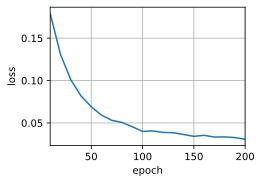

In [26]:
class DecoderBlock(nn.Module):
    def __init__(self,key_size,query_size,value_size,num_hiddens,norm_shape,ffn_num_input,
                 ffn_num_hiddens,num_heads,dropout,i,**kwargs):
        super(DecoderBlock,self).__init__(**kwargs)
        self.i=i
        self.attention1=MultiHeadAttention(key_size,query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1=Addnorm(norm_shape, dropout)
        self.attention2=MultiHeadAttention(key_size,query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2=Addnorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,num_hiddens)
        self.addnorm3=Addnorm(norm_shape, dropout)

    def forward(self,X,state):
        # state = [enc_outputs, enc_valid_lens, key_values]
        # enc_outputs:Encoder输出(batch_size, num_steps, num_hiddens)
        # enc_valid_lens(batch_size,)
        # key_values：长度等于解码器的层数num_layers
        # state[2][0]：第 0 层解码器块的历史缓存，即[batch_size,time_steps,hidden_dims]
        enc_outputs,enc_valid_lens=state[0],state[1]
        # state[2][self.i]：第self.i层解码器块的历史缓存，包含Key/Value信息
        # 训练阶段：state[2][self.i]初始化为None（第一步也走这条路咯）
        # 预测阶段：state[2][self.i]包含着直到当前时间步第i个解码Block的输出表示
        if state[2][self.i] is None:
            key_values=X # 训练阶段的X是整句正确答案的词嵌入（Embedding）+ 位置编码
        else:
            key_values=torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i]=key_values
        if self.training:
            batch_size,num_steps,_=X.shape
            # dec_valid_lens:[batch_size,num_steps]
            # 每一行是[1,2,...,num_steps]——下三角矩阵
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2=self.attention1(X,key_values,key_values,dec_valid_lens)
        Y=self.addnorm1(X,X2)
        # 编码器——解码器注意力：
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y,Y2)
        return self.addnorm3(Z,self.ffn(Z)),state
    
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape
print(decoder_blk.training)

class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                                 DecoderBlock(key_size, query_size, value_size, num_hiddens,
                                              norm_shape, ffn_num_input, ffn_num_hiddens,
                                              num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens,vocab_size)

    def init_state(self,enc_outputs,enc_valid_lens,*args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    
    def forward(self,X,state):
        X=self.pos_encoding(self.embedding(X)*math.sqrt(self.num_hiddens))
        self._attention_weights=[[None]*len(self.blks) for _ in range(2)] # 有自注意和解码编码注意力两层
        for i,blk in enumerate(self.blks):
            X,state=blk(X,state)
            # 解码器自注意力权重
            self._attention_weights[0][i]=blk.attention1.attention.attention_weights
            # 编码器-解码器 自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X),state
    
    @property
    def attention_weights(self):
        return self._attention_weights
    

# 训练过程：
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq_local(net, train_iter, lr, num_epochs, tgt_vocab, device)

# 计算BLEU分数
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')



In [27]:
# 可视化Transformer的注意力权重
# 编码器自注意力权重的形状为（编码器层数，注意力头数，num_steps或查询的数目，num_steps或“键－值”对的数目
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

In [ ]:
# 评估举例
